In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.coordinates as coord
from matplotlib import colors
from scipy.interpolate import interp1d

import Gaia_helpers as gh
import orbit_helpers as oh
import phot_helpers as ph

In [2]:
fname = 'BH_STARS_EVOLVED.gz'
#fname = 'BH_stars_loose_EVOLVED.gz'
#fname = 'BH_stars_loose_modmetal_EVOLVED.gz'

In [3]:
dat = pd.read_pickle(fname)

In [4]:
dat.columns

Index(['#simname', 'M_sc[Msun]', 'D_frac', 'Z', 'dense/loose[0/1]', 'i1', 'i2',
       'M1[Msun]', 'M2[Msun]', 'K1', 'K2', 'M1form[Msun]', 'M2form[Msun]',
       'K1form', 'K2form', 'Tform(0=primordial)[Myr]',
       'Tesc(100=retained)[Myr]', 'Vesc(0=retained)[km/s]', 'e', 'P[days]',
       'a[AU]', 'sigmamaxw[km/s]', 'sntype[0=delayed/1=rapid]', 'alphaCE', 'x',
       'y', 'z', 'kern_len', 'formation_time', 'met_particle', 'B_TPHYF[MYRS]',
       'B_KSTAR1', 'B_KSTAR2', 'B_M1[Msun]', 'B_M2[Msun]', 'B_logL1[Lsun]',
       'B_logL2[Lsun]', 'B_logR1[Rsun]', 'B_logR2[Rsun]', 'B_logT1[K]',
       'B_logT2[K]', 'B_ECC', 'B_PORB[Days]', 'B_SEP[Rsun]'],
      dtype='object')

#### Rename some columns so they work with my scripts

In [5]:
dat = dat.rename(columns={"B_M1[Msun]": "mass_1", "B_M2[Msun]": "mass_2", 
                          "B_SEP[Rsun]": "sep", "B_PORB[Days]": "porb", "Z": "metallicity",
                          "B_ECC": "ecc", "x": "X", "y": "Y", "z": "Z"})

In [6]:
dat['FeH'] = np.log10(dat.metallicity.values/0.02)
dat['rad_1'] = 10**dat['B_logR1[Rsun]'].values
dat['rad_2'] = 10**dat['B_logR2[Rsun]'].values
dat['lum_1'] = 10**dat['B_logL1[Lsun]'].values
dat['lum_2'] = 10**dat['B_logL2[Lsun]'].values
dat['teff_1'] = 10**dat['B_logT1[K]'].values
dat['teff_2'] = 10**dat['B_logT2[K]'].values
c = SkyCoord(x=np.array(dat.X) * u.kpc,
                 y=np.array(dat.Y) * u.kpc, 
                 z=np.array(dat.Z) * u.kpc,
                 frame=coord.Galactocentric,
                 galcen_distance = 8.5 * u.kpc,
                 z_sun = 36.0e-3 * u.kpc)
dat['dist'] = c.transform_to(coord.ICRS).distance.value

#### Filter out things that aren't around at present based on Poojan's suggestion

In [7]:
dat = dat.loc[dat["B_TPHYF[MYRS]"] > 0]

#### Select on BH + bright companions; could make non-degenerate by changing 13 to 10

In [8]:
dat = dat.loc[((dat.B_KSTAR1 == 14) & (dat.B_KSTAR2 < 13)) | ((dat.B_KSTAR2 == 14) & (dat.B_KSTAR1 < 13))]

#### Filter out unbound systems and those with orbital periods longer than 10 years

In [9]:
dat = dat.loc[(dat.ecc >= 0) & (dat.porb < 10 * 365.25)]

#### Load the bolometric correction grid from MIST

In [10]:
from isochrones.mist.bc import MISTBolometricCorrectionGrid

bc_grid = MISTBolometricCorrectionGrid(['J', 'H', 'K', 'G', 'BP', 'RP'])

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [11]:
dat = ph.get_phot(sim_set=dat, sys_type=2, bc_grid=bc_grid)

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 44.116 s
  pix_info:   1.132 s
   samples:  19.166 s
      best:   9.487 s
       nan:   0.055 s
      sort:  14.105 s
       idx:   0.170 s
pop size before extinction cut: 508232
pop size after extinction cut: 508232


#### Filter on Gaia G < 20

In [12]:
dat = dat.loc[dat.G_app < 20]

#### Give random orientations to each binary so that we can get the projected size of the star's orbit

In [13]:
dat['inc'] = np.arccos(np.random.uniform(0,1,len(dat)))
dat['omega'] = np.random.uniform(0, 2 * np.pi, len(dat))
dat['OMEGA'] = np.random.uniform(0, 2 * np.pi, len(dat))


In [14]:
dat = oh.get_projected_orbit(dat, bintype='co')

In [15]:
dat['sigma_al'] = oh.get_sigma_AL(dat.G_app)

In [16]:
dat.sep_phot/dat.dist

1636       0.182247
2434       0.158670
2609       0.321675
3802       0.171447
3848       0.148007
             ...   
1572030    0.035238
1572032    0.006893
1572189    0.004070
1572218    0.455608
1572224    0.009809
Length: 1797, dtype: float64

#### Get Gaia RUWE and filter on RUWE (rho) > 1

In [17]:
dat = oh.get_delta_theta(dat)
dat = oh.get_rho(dat)
print(len(dat.loc[dat.rho > 1]))
print(len(dat.loc[dat.sep_phot/dat.dist > 1 * dat.sigma_al]))

1797
136


### Whelp -- I bungled this one in the earlier versions. The rho parameter is the RUWE and shouldn't be used for individual detections :-(

In [18]:
print(f"The size of the pessimistic BH binary population detectable by Gaia is: {len(dat.loc[dat.sep_phot/dat.dist > 3 * dat.sigma_al])}")
print(f"The size of the optimistic BH binary population detectable by Gaia is: {len(dat.loc[dat.sep_phot/dat.dist > dat.sigma_al])}")

The size of the pessimistic BH binary population detectable by Gaia is: 46
The size of the optimistic BH binary population detectable by Gaia is: 136


In [19]:
dat_opt = dat.loc[dat.sep_phot/dat.dist > 1 * dat.sigma_al]
dat_pess = dat.loc[dat.sep_phot/dat.dist > 3 * dat.sigma_al]

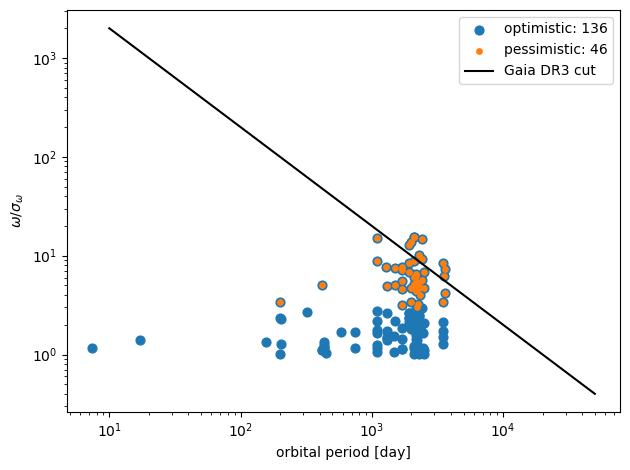

In [25]:
plt.scatter(dat_opt.porb, (dat_opt.sep_phot/dat_opt.dist)/dat_opt.sigma_al, label='optimistic: {}'.format(len(dat_opt)), s=40)
plt.scatter(dat_pess.porb, (dat_pess.sep_phot/dat_pess.dist)/dat_pess.sigma_al, label='pessimistic: {}'.format(len(dat_pess)), s=15)
plt.plot(np.linspace(10, 50000, 100), 20000/np.linspace(10, 50000, 100), c='black', label='Gaia DR3 cut')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('orbital period [day]')
plt.ylabel(r'$\omega/\sigma_{\omega}$')
plt.legend()
plt.tight_layout()
plt.savefig('DR3_cut_dense.png', facecolor='white', dpi=100)

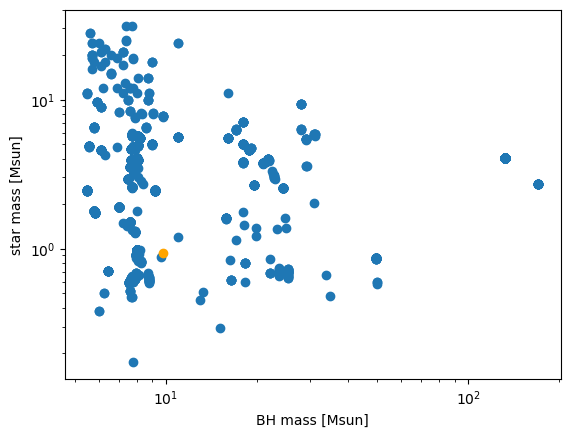

In [21]:
plt.scatter(dat.mass_1, dat.mass_2)
plt.scatter(9.8, 0.93, c='orange', zorder=1)
plt.xlabel('BH mass [Msun]')
plt.ylabel('star mass [Msun]')
plt.xscale('log')
plt.yscale('log')

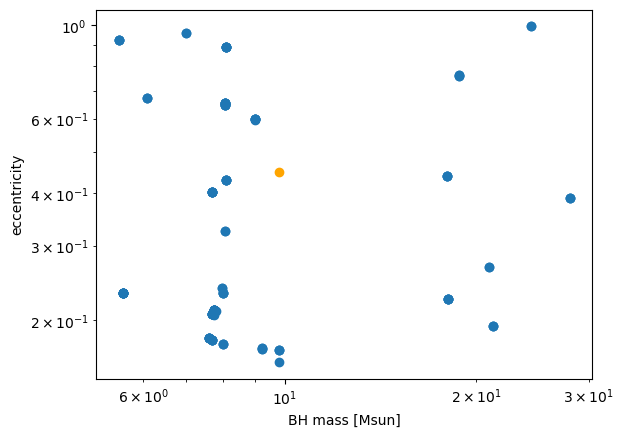

In [22]:
plt.scatter(dat_opt.mass_1, dat_opt.ecc)
plt.scatter(9.8, 0.45, c='orange')
plt.xlabel('BH mass [Msun]')
plt.ylabel('eccentricity')
plt.xscale('log')
plt.yscale('log')

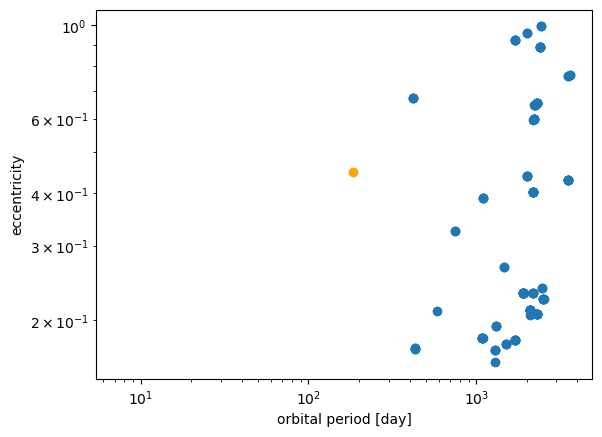

In [23]:
plt.scatter(dat_opt.porb, dat_opt.ecc)
plt.scatter(185, 0.45, c='orange')
plt.xlabel('orbital period [day]')
plt.ylabel('eccentricity')
plt.xscale('log')
plt.yscale('log')